# Decision Tree Training and Analysis

In [1]:
import sqlite3
import os
from datetime import datetime
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Import Data from Database

In [2]:

conn = sqlite3.connect('../features.db')
c = conn.cursor()

# Get training, validation, and test data
train = pd.read_sql_query("SELECT * FROM train", conn)
valid = pd.read_sql_query("SELECT * FROM validation", conn)
test = pd.read_sql_query("SELECT * FROM test", conn)

# Close the connection
conn.close()

## Format Data for Machine Learning

In [5]:
# Get the target and features
train_y = train['y'].map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
train_x = train.drop(columns=['y'])

valid_y = valid['y'].map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
valid_x = valid.drop(columns=['y'])

test_y = test['y'].map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
test_x = test.drop(columns=['y'])

# Drop id column
train_x = train_x.drop(columns=['id'])
valid_x = valid_x.drop(columns=['id'])
test_x = test_x.drop(columns=['id'])

print('train_x shape:', train_x.shape)
print('test_x shape:', test_x.shape)
print('valid_x shape:', valid_x.shape)

# Print column names
print('features:', train_x.columns.to_list())
feature_names = train_x.columns.to_list()

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

train_x = imputer.fit_transform(train_x)
valid_x = imputer.transform(valid_x)
test_x = imputer.transform(test_x)

# Scale data between 0 and 1
scaler = MinMaxScaler()

# Fit the scaler to your data and then transform it
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)
test_x = scaler.transform(test_x)

# Use DecisionTreeClassifier
num_classes = len(set(valid_y.to_list()))
print('number of classes:', num_classes)

train_x shape: (3502, 10)
test_x shape: (438, 10)
valid_x shape: (438, 10)
features: ['age', 'gender', 'artial_rate', 'ventricular_rate', 'qrs_duration', 'qt_length', 'qrs_count', 'q_peak', 'r_axis', 't_axis']
number of classes: 4


# Test Grid for Hyperparameter Analysis

In [6]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}


In [7]:
# Create a DecisionTreeClassifier object
model = DecisionTreeClassifier()

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')

# Training

In [8]:

# Fit the grid search object to the data
grid_search.fit(train_x, train_y)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='accuracy')

# Results

In [9]:

# Print the best parameters and the best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')


Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best score: 0.769842911809933


# Save Model

In [10]:

# Save the best model
best_model = grid_search.best_estimator_

# Timestamp
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
model_path = f'../ml_models/best_decision_tree_model_{timestamp}.joblib'
dump(best_model, model_path)

['../ml_models/best_decision_tree_model_20240621173105.joblib']

# Example Training of best Model

load the best model to get the best hyperparameters from it

In [11]:
# List directory
models = os.listdir('../ml_models')
model_path = [model for model in models if 'joblib' in model and 'best' in model and 'decision_tree' in model][0]
model_path = f'../ml_models/{model_path}'

# Load the best model
best_model = load(model_path)

In [12]:
# Example training of a model with the best parameters
model = DecisionTreeClassifier(**grid_search.best_params_)
model.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=10)

In [13]:
# Predictions and accuracy
preds = best_model.predict(test_x)
accuracy = accuracy_score(test_y, preds)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.7990867579908676


# Evaluate Model Performance

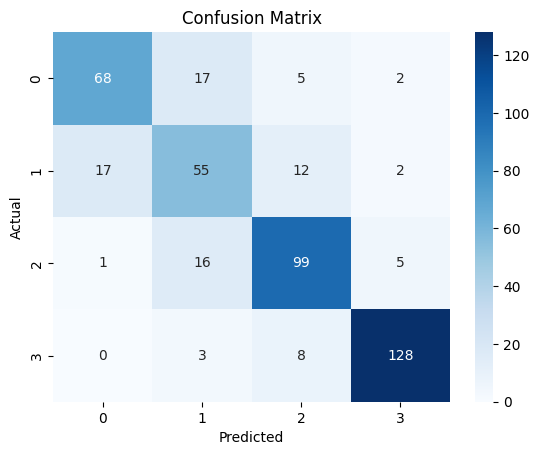

In [14]:
# Optional: Plot confusion matrix
cm = confusion_matrix(test_y, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

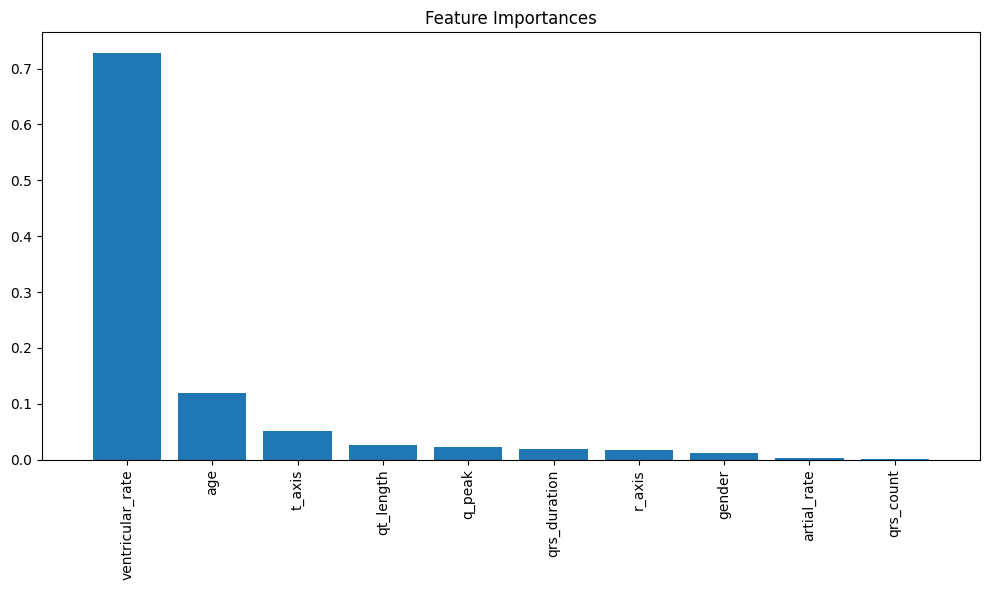

In [17]:
# plot the feature importance
import matplotlib.pyplot as plt
import numpy as np

feature_importances = model.feature_importances_
# Sort the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.tight_layout()
plt.show()

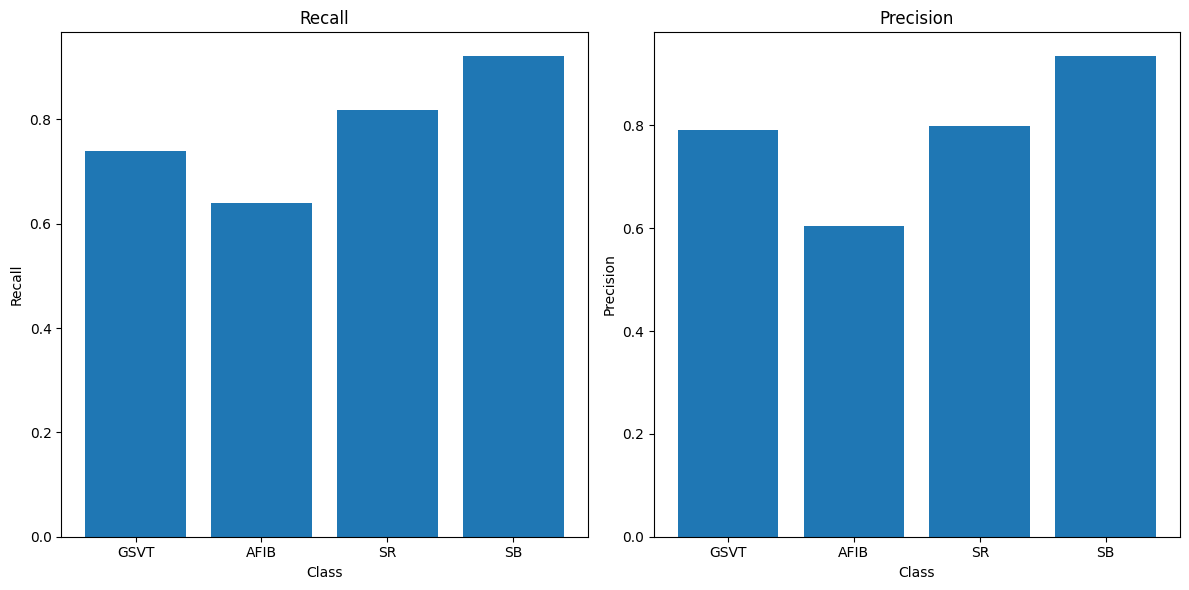

In [15]:
# plot recall and precision
# Calculate the recall and precision
recall = cm.diagonal() / cm.sum(axis=1)
precision = cm.diagonal() / cm.sum(axis=0)

# plot in a bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(range(num_classes), recall)
ax[0].set_xticks(range(num_classes))
ax[0].set_xticklabels(['GSVT', 'AFIB', 'SR', 'SB'])
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Recall')
ax[0].set_title('Recall')

ax[1].bar(range(num_classes), precision)
ax[1].set_xticks(range(num_classes))
ax[1].set_xticklabels(['GSVT', 'AFIB', 'SR', 'SB'])
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision')

plt.tight_layout()
plt.show()